In [1]:
# Restart the kernel
import os
current_dir ='../../../'
os.chdir(current_dir)

In [2]:
from src.codes.basic import *
from src.codes.utils import *
import src.codes.utils as utils

from src.codes.prob_classes.base_class_heat_conduction import FOS_FEM
from src.codes.prob_classes.base_class_heat_conduction import probdata

import src.codes.reductor.rom_class as rom_class
import src.codes.algorithms.deim_test as deim_module
from importlib import reload

### class for data (geometry, material property, mesh)

In [3]:
nref= [3,3,3]
L = [10.,12.,14.]

mat_layout = np.zeros((4,4,4),dtype=int)
src_layout = np.zeros((4,4,4),dtype=int)

# src_layout[0,0,0] = 1
# src_layout[1,1,1] = 1
# src_layout[2,2,2] = 1
# src_layout[3,3,3] = 1

In [4]:
fdict = {}

cond_list = []
cond_list.append( lambda T,mu: 10*np.exp(mu)*T + 100. + 0.*T )
fdict["cond"] = cond_list

dcond_list = []
dcond_list.append( lambda T,mu: 10*np.exp(mu) + 0. + 0.*T )
fdict["dcond"] = dcond_list

qext_list = []
qext_list.append( lambda T,mu: 0.0+100.0 + 0.*T )
fdict["qext"] = qext_list

dqext_list = []
dqext_list.append( lambda T,mu: 0.0 + 0.*T)
fdict["dqext"] = dqext_list

In [5]:
bc = {}
bc['x_min']={'type':'dirichlet','value':0.}
bc['x_max']={'type':'dirichlet','value':0.}
bc['y_min']={'type':'dirichlet','value':0.}
bc['y_max']={'type':'dirichlet','value':0.}
bc['z_min']={'type':'dirichlet','value':0.}
bc['z_max']={'type':'dirichlet','value':0.}

### Simulate FOS

In [6]:
random.seed(25)
params = np.r_[1.:4.0:0.01]
quad_deg = 3
N_snap = 15 # Training Snapshots
NL_solutions = []
param_list = []

In [7]:
def plot3Da(x, y, z, Z, hmap=False, sz=1.0, clr='b', save_file=False):
    """
    Function: plot3D
    Overview: This function generates a 3D scatter plot for a given data set. It offers the option
    to either color the points based on a heatmap or use a uniform color.
    
    Inputs:
    - x, y, z: 1D arrays representing the x, y, and z coordinates of the data points.
    - Z: 1D array representing the values at each data point for the heatmap.
    - hmap: Boolean flag to enable heatmap coloring (default is False).
    - sz: Size of the scatter points (default is 1.0).
    - clr: Color for the scatter points when not using heatmap (default is 'b' for blue).
    - save_file: Boolean flag to enable saving the plot to a file (default is False).
    
    Outputs:
    - Generates a 3D scatter plot and displays it.
    - Optionally saves the plot to a VTK file if save_file is True.
    
    Example usage:
    plot3D(x, y, z, Z, hmap=True, sz=1.0, clr='b', save_file=False)
    """
    
    from matplotlib import rcParams
    rcParams['mathtext.fontset'] = 'stix'
    rcParams['font.family'] = 'STIXGeneral'
    rcParams['font.size'] = 25
    plt.rc('text', usetex=True)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    Z3d = np.reshape(Z,(len(z),len(y),len(x))).T
    
    xx, yy, zz = np.meshgrid(x,y,z)
    
    if hmap==True:
        sc = ax.scatter(xx.flatten(), yy.flatten(), zz.flatten(), c=Z3d, cmap=cm.coolwarm,s=4)
        ax.set_xlabel('$x$',)
        ax.set_ylabel('$y$')
        ax.set_zlabel('$z$',labelpad=-10)
        ax.view_init(elev=10, azim=-60)
        plt.colorbar(sc,shrink=0.5)
        
    else:
        # Second scatter plot
        ax.scatter(xx.flatten(), yy.flatten(), zz.flatten(), c=clr, s=sz)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.set_zlabel('$z$')

    ax.set_xticklabels([])
    ax.set_xticks([])

    ax.set_yticklabels([])
    ax.set_yticks([])

    ax.set_zticklabels([])
    ax.set_zticks([])
        
    plt.autoscale(tight=True)
    plt.show()


    
    if save_file:
        from pyevtk.hl import gridToVTK
        gridToVTK("/structured"+f"{i}"+"100",  x,  y,  z, \
                  pointData = {"temp" : Z3d})



 Snap 0


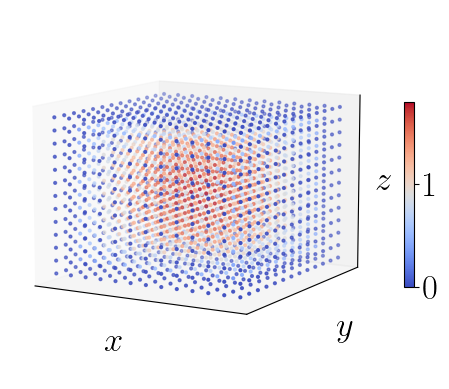


 Snap 1

 Snap 2

 Snap 3

 Snap 4

 Snap 5

 Snap 6

 Snap 7

 Snap 8

 Snap 9

 Snap 10

 Snap 11

 Snap 12

 Snap 13

 Snap 14


In [8]:
for i in range(N_snap):
    print(f"\n Snap {i}")
    param = random.choice(params) # Choose from parameter list
    param_list.append(param)
    
    if i==0:
        d = probdata(bc, mat_layout, src_layout, fdict, nref, L, param, pb_dim=3)
        FOS = FOS_FEM(d,quad_deg)
    else:
        FOS.mu = param
    T_init = np.zeros(d.n_verts) + 4.0
    NL_solution_p, Ke, rhs_e, mask = solve_fos(FOS, T_init)
    NL_solutions.append(NL_solution_p.flatten())

    if i<1:
        plot3Da(d.xi[0], d.xi[1], d.xi[2], NL_solutions[i], hmap=True)

In [9]:
NLS = np.asarray(NL_solutions)
np.shape(NLS)

(15, 2197)

### DEIM Hyper-reduction


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

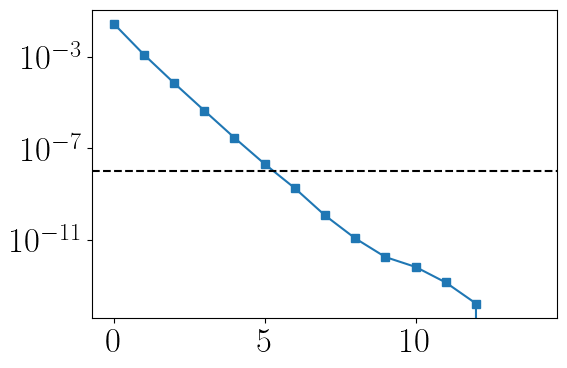

6


In [10]:
n_sel, U = svd_mode_selector(NL_solutions, tol_f=1e-8)
V_sel = U[:, :n_sel]
print(n_sel)

In [11]:
# for i in range(n_sel):
#     plot3D(d.xi[0],d.xi[1],d.xi[2],V_sel[:,i],hmap=True)

### Step 2: Perform SVD on the force snapshots

In [12]:
reload(deim_module)

<module 'src.codes.algorithms.deim_test' from 'd:\\D\\ONEDRIVE\\OneDrive - Texas A&M University\\TAMU_MATERIALS\\POSTDOC\\HYPERREDUCTION\\SUPARNO\\Hyperreduction_tamids\\pyHyperRom\\src\\codes\\algorithms\\deim_test.py'>

In [13]:
deim = deim_module.deim(FOS,param_list,V_sel,NLS,mask,tol_f=3e-15)

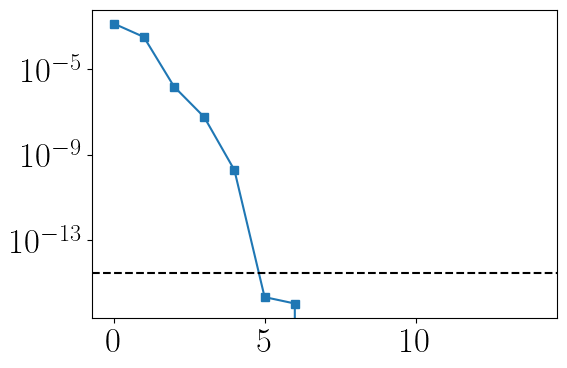

6


In [14]:
tic_h_setup_b = time.time()
deim.select_elems()
toc_h_setup_b = time.time()
print(deim.n_f_sel)

In [15]:
xi = deim.xi

colors = ['red' if value > 0 else 'blue' for value in xi]
sizes = [15 if value > 0 else 1 for value in xi]

print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")

Fraction of total elements active in the ROM: 2.314814814814815%


In [16]:
mask_xi = xi>0

In [17]:
# # Update the grid size to 20x20
# fig, ax = plt.subplots()

# # Draw the grid lines
# for x in range(grid_size[0] + 1):
#     ax.axhline(x, lw=0.5, color='white')
# for y in range(grid_size[1] + 1):
#     ax.axvline(y, lw=0.5, color='white')


# for x in range(grid_size[0]):
#     for y in range(grid_size[1]):
#         rect = plt.Rectangle((y, grid_size[0] - x - 1), 1, 1, linewidth=1, edgecolor='none', facecolor='orange')
#         ax.add_patch(rect)

        
# # Color all the cells in the specific 20x20 grid orange
# for i in range(len(xi)):

#     if mask_xi[i]:
#         x,y = FOS.e_n_2ij(i, el=True)
#         rect = plt.Rectangle((x,y), 1, 1, linewidth=1, edgecolor='none', facecolor='#169C9A')
#         ax.add_patch(rect)


# # Set the aspect ratio to be equal
# ax.set_aspect('equal')

# ax.set_yticklabels([])
# ax.set_yticks([])

# ax.set_xticklabels([])
# ax.set_xticks([])


# plt.xlim(0, grid_size[1])
# plt.ylim(0, grid_size[0])
# plt.show()


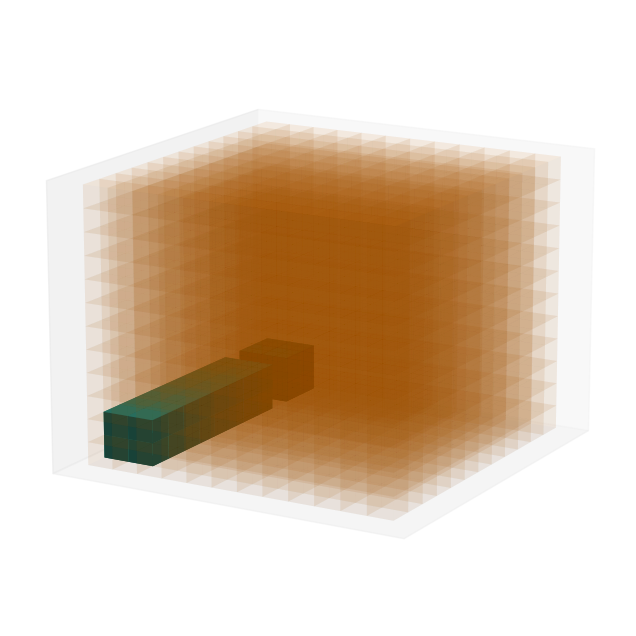

In [35]:
# It appears that the variable grid_size was lost. Let's define it again along with the required libraries.
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Define the grid size as 20x20x20 for the 3D grid
grid_size = (d.ncells[0], d.ncells[1], d.ncells[2])


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Define some specific cells to have different transparency within the cube
# Using (x, y, z, alpha) where alpha is the transparency level (0.0 to 1.0)
# specific_cells = [(5, 5, 5, 1.0), (10, 10, 10, 1.0), (15, 15, 15, 1.0)]

# Draw the 3D grid and color the cells
for x in range(grid_size[0]):
    for y in range(grid_size[1]):
        for z in range(grid_size[2]):  # Using depth as the third dimension
            alpha_value = 0.1/2  # Default transparency
            clr = (1, 0.5, 0, alpha_value)
            ax.bar3d(x, y, z, 1, 1, 1, shade=True, color=clr)  # RGB color for orange


# Color all the cells in the specific 20x20 grid orange
for i in range(len(xi)):

    if mask_xi[i]:
        x,y,z = FOS.e_n_2ij(i, el=True)
        clr = (0.08627450980392157, 0.611764705882353, 0.6039215686274509,1.0)
        ax.bar3d(x, y, z, 1, 1, 1, shade=True, color=clr)  # RGB color for orange

# Set axis limits for better visualization
# ax.set_xlim([0, grid_size[0]])
# ax.set_ylim([0, grid_size[1]])
# ax.set_zlim([0, grid_size[2]])

ax.set_yticklabels([])
ax.set_yticks([])

ax.set_xticklabels([])
ax.set_xticks([])

ax.set_zticklabels([])
ax.set_zticks([])

for spine in ['top', 'right', 'left','bottom']:
    ax.spines[spine].set_visible(False)


# Remove the black frame (spines) in the front along the axes
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # Make x-axis spine invisible
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # Make y-axis spine invisible
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # Make z-axis spine invisible


# Change view angle for better visualization
ax.view_init(elev=15, azim=30)

plt.show()


In [19]:
# plot3D(np.arange(d.ncells[0]),np.arange(d.ncells[1]),np.arange(d.ncells[2]),xi, sz = sizes, clr = colors, save_file=False)

### ROM Simulation

In [20]:
# Choose unknown parameter

params_rm = params[~np.isin(params,param_list)]
param_rom = 1.0
# random.choice(params_rm)

In [21]:
# Define the data-class

d_test = probdata(bc, mat_layout, src_layout, fdict, nref, L, param_rom, pb_dim=3)
FOS_test = FOS_FEM(d_test,quad_deg)
ROM_h = rom_class.rom_deim(d_test, deim, quad_deg)
ROM = rom_class.rom(d_test, quad_deg)

In [22]:
# Initial guess

T_init_fos = np.zeros(FOS_test.n_nodes) + 2.
T_init_rom = np.transpose(V_sel)@T_init_fos # crucial to ensure the initial guess is contained in the reduced subspace

In [23]:
# # Time taken to perform a FO simulation with the current parameter value

tic_fos = time.time()
NL_solution_p_fos_test, _, _, _, = solve_fos(FOS_test,T_init_fos)
toc_fos = time.time()

In [24]:
# # Time taken to simulate a ROM without hyper-reduction

# tic_rom_woh = time.time()
# NL_solution_p_reduced_woh = ROM.solve_rom(T_init_rom,V_sel)
# toc_rom_woh = time.time()

In [25]:
xi

array([1., 1., 0., ..., 0., 0., 0.])

In [26]:
# Time taken to simulate a ROM *with* hyper-reduction

tic_rom = time.time()
NL_solution_p_reduced_test = ROM_h.solve_rom(T_init_rom,xi,V_sel)
toc_rom = time.time()

c:\Users\supar\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [27]:
speed_up = []
fos_sim_time = toc_fos - tic_fos

for i in range(100):
    param_rom = random.choice(params_rm)
    d_test.mu = param_rom

    tic_rom = time.time()
    ROM_h = rom_class.rom_deim(d_test, deim, quad_deg)
    NL_solution_p_reduced_loop = ROM_h.solve_rom(T_init_rom,xi,V_sel)
    toc_rom = time.time()
    
    rom_sim_time = toc_rom - tic_rom
    speed_up.append(fos_sim_time/(rom_sim_time))
    

### Check

In [ ]:
FOS_test_loop = FOS_FEM(d_test,quad_deg)
NL_solution_p_fos_test_loop, _, _, _, = solve_fos(FOS_test_loop,T_init_fos)

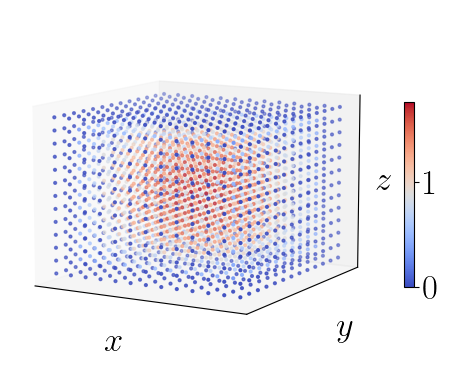

RMS_error is 0.0009773496030758323 %


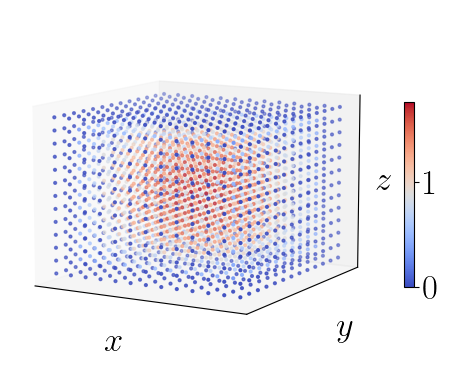

In [31]:

sol_red_loop = V_sel@NL_solution_p_reduced_loop.reshape(-1,1)  #+pca.mean_.reshape(-1,1)
plot3Da(d_test.xi[0], d_test.xi[1], d_test.xi[2], sol_red_loop,hmap=True)

print(f"RMS_error is {np.linalg.norm(sol_red_loop-NL_solution_p_fos_test_loop.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test_loop.reshape(-1,1))} %")
plot3Da(d_test.xi[0], d_test.xi[1], d_test.xi[2], NL_solution_p_fos_test_loop, hmap=True)

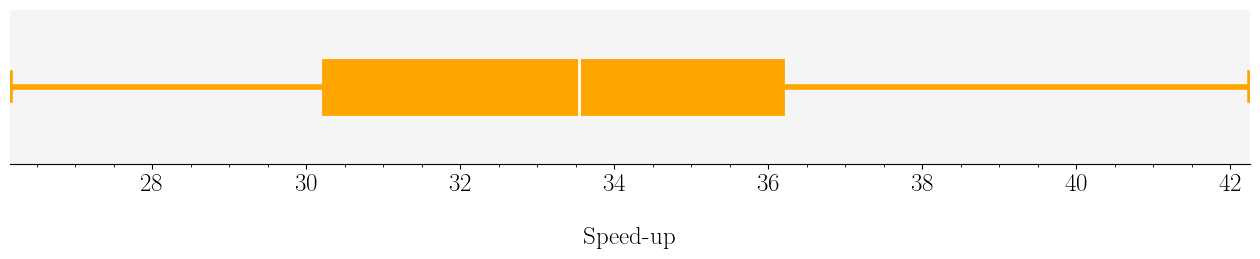

In [32]:
from matplotlib import rcParams

# rcParams['font.family'] = 'Latin Modern Roman 10'
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size'] = 18

# Create Figure and Axes
fig, ax = plt.subplots(figsize=(8*2, 1*2))
ax.set_facecolor('#f5f5f5')  # Using the HEX code for gray

# Create Box Plot with patch_artist=True
box = ax.boxplot(speed_up, vert=False, patch_artist=True,widths=0.35,
                 boxprops=dict(linewidth=2.0, color='orange'),
                 whiskerprops=dict(linewidth=4.0, color='orange'),
                 capprops=dict(linewidth=4.0, color='orange'),
                 medianprops=dict(linewidth=2.0, color='white'),
                 flierprops=dict(marker='.', markerfacecolor='#ffb300', markeredgecolor='#ffb300', markersize=8, linestyle='none'))


ax.set_ylim(0.9, 1.1)

# Set Box Fill Color
for patch in box['boxes']:
    patch.set_facecolor('orange')

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

ax.set_yticklabels([])
ax.set_yticks([])
plt.xlabel('\n Speed-up')
plt.autoscale(enable=True, tight=True)
ax.minorticks_on()

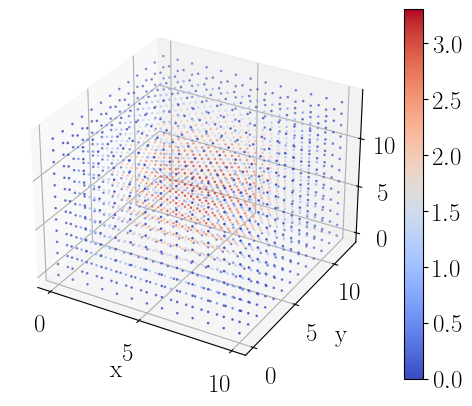

RMS_error is 0.0015171791021039269 %


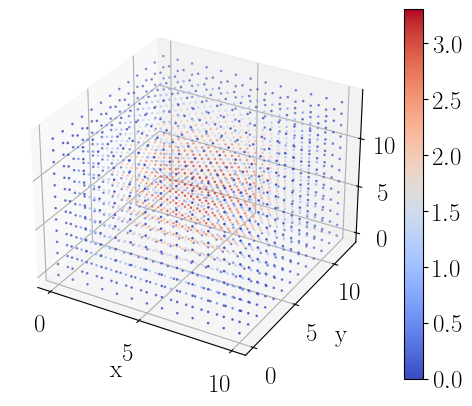

In [36]:
sol_red = V_sel@NL_solution_p_reduced_test.reshape(-1,1)  #+pca.mean_.reshape(-1,1)

plot3D(d_test.xi[0], d_test.xi[1], d_test.xi[2], sol_red,hmap=True)
print(f"RMS_error is {np.linalg.norm(sol_red-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")

plot3D(d_test.xi[0], d_test.xi[1], d_test.xi[2], NL_solution_p_fos_test,hmap=True)

# print(f"\n\nROM Error without hyperreduction is {np.linalg.norm(V_sel@NL_solution_p_reduced_woh.reshape(-1,1)-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")

 
### Speedups

In [ ]:
# fos_sim_time = toc_fos - tic_fos
# rom_sim_time_woh = toc_rom_woh - tic_rom_woh
# rom_sim_time = toc_rom - tic_rom

In [ ]:
# print(f"speedup without hyperreduction:{fos_sim_time/rom_sim_time_woh}")
# print(f"speedup with hyperreduction:{fos_sim_time/(rom_sim_time)}")
# # h_total_setup_time = (toc_h_setup_b+toc_h_setup_a) - (tic_h_setup_b+tic_h_setup_a) #this is one time